In [128]:
import pandas as pd

from scipy import stats
import numpy as np


import holidays 

import matplotlib.pyplot as plt

In [111]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 150 # 200 e.g. is really fine, but slower

In [119]:
today = pd.to_datetime('today')
eng_hols = holidays.England(years=range(1990, today.year)).keys()
weekdays = set(pd.bdate_range(start='1990-01-01', end=today).date)
business_dates = pd.DataFrame(index = weekdays - eng_hols).sort_index()

def extract_valid_daily_changes(data: pd.DataFrame, price_column: str, business_dates: pd.DataFrame):
    '''
    Calculate difference between actual consecutive days, to account for possible missing days,
    which would result in incorrect daily change data.
    '''
    df = business_dates.copy()
    df[price_column] = data[price_column]
    daily_change = df[price_column] / df[price_column].shift(1) - 1
    
    return np.sort(np.array(daily_change.dropna()))

In [120]:
x = context.catalog.load('alphavantage_etf_historical_cleansed')

2021-05-18 20:59:02,917 - kedro.io.data_catalog - INFO - Loading data from `alphavantage_etf_historical_cleansed` (PartitionedDataSet)...


In [121]:
df = x['SLXX.LON']()

In [133]:
df.index = pd.to_datetime(df.date)

In [138]:
data = extract_valid_daily_changes(df, 'adjusted_close', business_dates)
data

array([-0.07895767, -0.06950321, -0.05580085, ...,  0.04867289,
        0.05726679,  0.08116564])

In [148]:
%%capture --no-stdout

# top distributions which best fit a assymetric pct difference distribution 
pct_diff_dists = [
    'nct',
    'johnsonsu',
    'tukeylambda',
    't'
]


def multiple_dist_goodness_of_fit(data):
    # loop through each distribution
    results = []
    for i in list_of_dists:
        dist = getattr(stats, i)
        param = dist.fit(data)
        a = stats.kstest(data, i, args=param)
        mx = 100-100*dist.cdf(max(data), *param)
        mn = 100*dist.cdf(min(data), *param)
        results.append((i,*a, mn, mx))

    results.sort(key=lambda x:float(x[2]), reverse=True)
    for j in results:
        print("{}: statistic={}, pvalue={}, P(<min)={:.3f}%, P(>max)={:.3f}%".format(*j), flush=True)

for symbol, data in x.items():
    if symbol != 'EUE.LON':
        continue
    df = data()
    df.index = pd.to_datetime(df.date)
    daily = extract_valid_daily_changes(df, 'adjusted_close', business_dates)
    print(symbol + ': ')
    multiple_dist_goodness_of_fit(daily)

EUE.LON: 
norminvgauss: statistic=0.013285550337661767, pvalue=0.457077385750981, P(<min)=0.005%, P(>max)=0.007%
johnsonsu: statistic=0.014643582156824153, pvalue=0.3366141728886064, P(<min)=0.017%, P(>max)=0.021%
laplace_asymmetric: statistic=0.02298731824052147, pvalue=0.025281819985734977, P(<min)=0.001%, P(>max)=0.002%
recipinvgauss: statistic=nan, pvalue=nan, P(<min)=nan%, P(>max)=nan%
t: statistic=0.01499809443350375, pvalue=0.3089566179175324, P(<min)=0.032%, P(>max)=0.048%
nct: statistic=0.01590697481409553, pvalue=0.24541402771498577, P(<min)=0.038%, P(>max)=0.040%
hypsecant: statistic=0.018715318444663565, pvalue=0.11009242048041956, P(<min)=0.000%, P(>max)=0.001%
dgamma: statistic=0.01875819324598338, pvalue=0.10864162145788991, P(<min)=0.001%, P(>max)=0.002%
dweibull: statistic=0.019064884201661747, pvalue=0.09871854749730646, P(<min)=0.000%, P(>max)=0.002%
gennorm: statistic=0.020963176378497983, pvalue=0.052707757413085976, P(<min)=0.001%, P(>max)=0.002%
laplace: statisti

semicircular: statistic=1.0, pvalue=0.0, P(<min)=0.000%, P(>max)=100.000%
trapezoid: statistic=0.5495296199912112, pvalue=0.0, P(<min)=1.197%, P(>max)=11.121%
truncexpon: statistic=0.47037541009511225, pvalue=0.0, P(<min)=0.001%, P(>max)=0.000%
truncnorm: statistic=0.7629202333159282, pvalue=0.0, P(<min)=0.000%, P(>max)=0.000%
uniform: statistic=0.3730335823505503, pvalue=0.0, P(<min)=0.000%, P(>max)=0.000%
vonmises: statistic=6.865357827171492e+27, pvalue=0.0, P(<min)=-686535782717149199969678262272.000%, P(>max)=-612780709170794588535254941696.000%
vonmises_line: statistic=1.0, pvalue=0.0, P(<min)=0.000%, P(>max)=100.000%
wald: statistic=0.4083953023652601, pvalue=0.0, P(<min)=0.000%, P(>max)=26.456%
wrapcauchy: statistic=nan, pvalue=nan, P(<min)=nan%, P(>max)=nan%


KstestResult(statistic=0.014643582156824153, pvalue=0.3366141728886064)


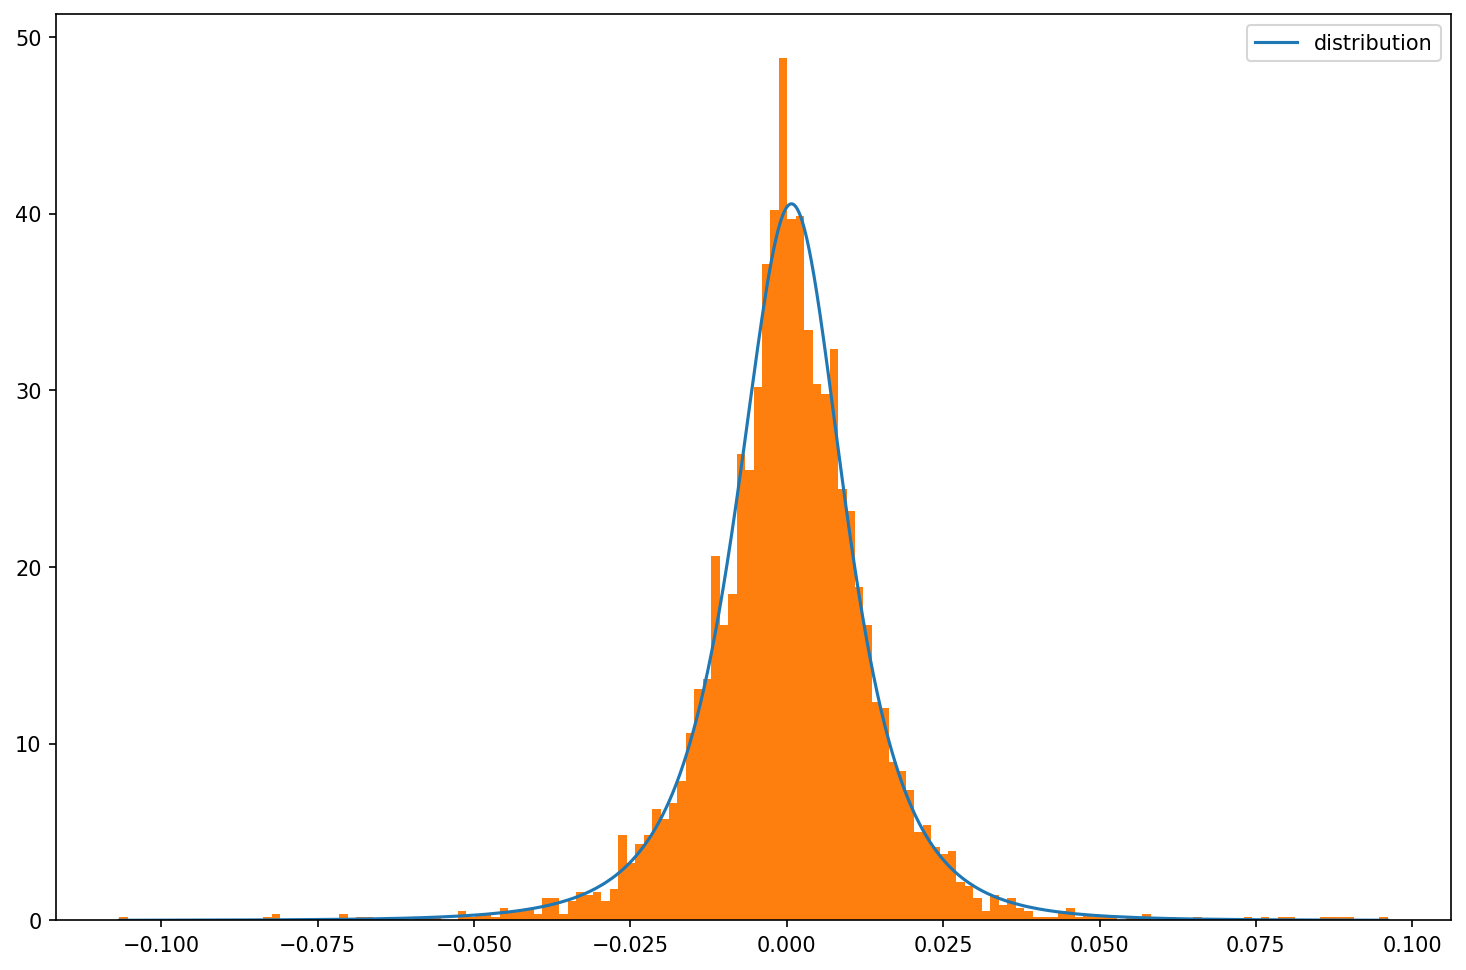

In [150]:
# plot sample, best distribution and normal distribution for comparison

df = x['EUE.LON']()
df.index = pd.to_datetime(df.date)
daily = extract_valid_daily_changes(df, 'adjusted_close', business_dates)
dist = getattr(stats, 'johnsonsu')
param = dist.fit(daily)
print(stats.kstest(daily, 'johnsonsu', args=param))

# distribution
pdf = dist.pdf(daily, *param)
plt.plot(daily, pdf, label='distribution')

# Sample histogram
plt.hist(daily, bins=150, density=True)

plt.legend();

In [154]:
daily[(daily > 0) & (daily < 0.002)]

array([7.89983182e-05, 8.58458257e-05, 1.00692401e-04, 1.03994932e-04,
       1.09341342e-04, 1.28006513e-04, 1.40587656e-04, 1.54299844e-04,
       1.55462689e-04, 1.56120445e-04, 1.74955965e-04, 1.89367763e-04,
       1.91457289e-04, 1.92663379e-04, 2.03186945e-04, 2.03296856e-04,
       2.33954803e-04, 2.34256072e-04, 2.44081745e-04, 2.89495474e-04,
       3.02275233e-04, 3.07660864e-04, 3.09492904e-04, 3.10899943e-04,
       3.13352333e-04, 3.14166505e-04, 3.14841122e-04, 3.15321826e-04,
       3.22116651e-04, 3.23801090e-04, 3.24653426e-04, 3.25557355e-04,
       3.27264907e-04, 3.28791266e-04, 3.30446329e-04, 3.30972689e-04,
       3.30986018e-04, 3.39344111e-04, 3.46863372e-04, 3.47010609e-04,
       3.48711388e-04, 3.60770877e-04, 3.65124012e-04, 3.75379501e-04,
       3.78047120e-04, 3.81230639e-04, 3.81401041e-04, 3.82212412e-04,
       3.84724200e-04, 3.84989735e-04, 3.86991846e-04, 3.90936861e-04,
       3.99755944e-04, 4.01001924e-04, 4.01727674e-04, 4.14420056e-04,
      

In [20]:
df

,date,open,high,low,close,adjusted_close,volume,dividend,split_coefficient
0,2005-01-04,698.0,699.0,698.00,699.0,462.8986,182237.0,0.0,1.0
1,2005-01-05,694.0,694.0,692.50,692.5,458.5945,105442.0,0.0,1.0
2,2005-01-06,692.0,694.5,692.00,692.5,458.5945,135473.0,0.0,1.0
3,2005-01-07,694.0,696.5,694.00,696.5,461.2430,230688.0,0.0,1.0
4,2005-01-10,702.5,702.5,695.50,696.5,461.2430,160256.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
4120,2021-05-05,2124.0,2138.0,2116.50,2126.0,2126.0000,679724.0,0.0,1.0
4121,2021-05-06,2132.0,2142.0,2127.53,2137.0,2137.0000,431151.0,0.0,1.0
4122,2021-05-07,2145.0,2165.0,2138.50,2165.0,2165.0000,549358.0,0.0,1.0
4123,2021-05-10,2169.5,2170.5,2151.76,2154.0,2154.0000,243931.0,0.0,1.0


In [58]:
from IPython.display import clear_output

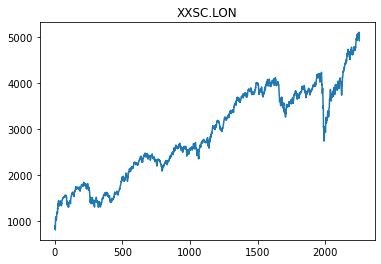

any errors? 


In [63]:
%matplotlib inline
errors = {}
for symbol, data in x.items():
    clear_output(wait=True)
    df = data()
    df.adjusted_close.plot(title=symbol)
    plt.show()
    error = input("any errors? ")
    if error == 'y': errors[symbol] = df

In [64]:
errors.keys()

dict_keys(['IBTS.LON', 'IGLS.LON', 'IITU.LON', 'INXG.LON', 'ITPS.LON', 'LQDS.LON'])

<AxesSubplot:>

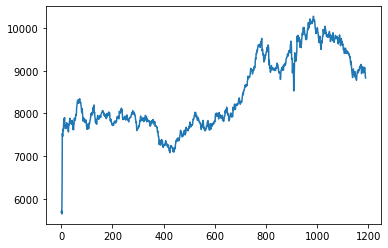

In [106]:
errors['LQDS.LON'].adjusted_close.plot()

In [108]:
errors['LQDS.LON'].head(40)

,date,open,high,low,close,adjusted_close,volume,dividend,split_coefficient
0,2012-03-07,6973.994,6981.635,6942.795,6942.795,5683.5604,23980.0,0.0,1.0
1,2012-03-12,6995.417,7008.225,6983.249,6983.249,5716.6771,35646.0,0.0,1.0
2,2012-03-13,6943.539,6944.174,6893.333,6893.333,5643.0695,69465.0,0.0,1.0
3,2015-01-14,7639.926,7669.505,7618.234,7618.234,6236.4932,18196.0,0.0,1.0
4,2016-06-28,8813.000,8847.969,8740.770,8813.000,7529.3081,53279.0,0.0,1.0
5,2016-06-29,8729.430,8766.880,8729.430,8729.430,7457.9107,4123.0,0.0,1.0
6,2016-06-30,8700.000,8754.591,8700.000,8754.591,7479.4071,47100.0,0.0,1.0
7,2016-07-01,8935.000,8947.780,8890.050,8935.000,7633.5378,15473.0,0.0,1.0
8,2016-07-04,8926.000,8926.000,8877.900,8883.000,7589.1122,2108.0,0.0,1.0
9,2016-07-05,9068.170,9068.170,9068.170,9068.170,7747.3104,64.0,0.0,1.0


In [140]:
list_of_dists = [
    'alpha',
    'anglit',
    'arcsine',
    'argus',
    'beta',
    'betaprime',
    'bradford',
    'burr',
    'burr12',
    'cauchy',
    'chi',
    'chi2',
    'cosine',
    'crystalball',
    'dgamma',
    'dweibull',
    'erlang',
    'expon',
    'exponnorm',
    'exponweib',
    'exponpow',
    'f',
    'fatiguelife',
    'fisk',
    'foldcauchy',
    'foldnorm',
    'genlogistic',
    'gennorm',
    'genpareto',
    'genexpon',
    'genextreme',
    'gausshyper',
    'gamma',
    'gengamma',
    'genhalflogistic',
    'geninvgauss',
    'gilbrat',
    'gompertz',
    'gumbel_r',
    'gumbel_l',
    'halfcauchy',
    'halflogistic',
    'halfnorm',
    'halfgennorm',
    'hypsecant',
    'invgamma',
    'invgauss',
    'invweibull',
    'johnsonsb',
    'johnsonsu',
    'kappa4',
    'kappa3',
    'ksone',
    #'kstwo',
    'kstwobign',
    'laplace',
    'laplace_asymmetric',
    'levy',
    'levy_l',
    #'levy_stable',
    'logistic',
    'loggamma',
    'loglaplace',
    'lognorm',
    'loguniform',
    'lomax',
    'maxwell',
    'mielke',
    'moyal',
    'nakagami',
    'ncx2',
    'ncf',
    'nct',
    'norm',
    'norminvgauss',
    'pareto',
    'pearson3',
    'powerlaw',
    'powerlognorm',
    'powernorm',
    'rdist',
    'rayleigh',
    'rice',
    'recipinvgauss',
    'semicircular',
    'skewnorm',
    't',
    'trapezoid',
    'triang',
    'truncexpon',
    'truncnorm',
    'tukeylambda',
    'uniform',
    'vonmises',
    'vonmises_line',
    'wald',
    'weibull_min',
    'weibull_max',
    'wrapcauchy',
]